# Obesity Risk Prediction using Tree-based models

This notebook trains tree-based models to predict obesity levels based on multi-class classification. The three following models will be trained and evaluated:  
- Baseline Decision Trees
- Random Forests  
- XGBoost.  

The simple **Baseline Decision Tree** performed best with an overall test accuracy of **XXX**. Both the **Random Forest Model** and the **XGBoost model** came pretty close with an accuracy of **XXX** and **XXX** respectively. More details on the performance of the models below.

## Imports

In [45]:
# Importing libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

<u>Disclaimer:</u>  

To avoid version incompatibilities and issues with the XGBoost model, it is necessary to use `scikit-learn==1.5.2.` (please follow the requirements.txt).

## Data Splitting

In [19]:
# Load split data from feather files
train_path = os.path.join("..", "processed_data", "train_data.feather")
test_path = os.path.join("..", "processed_data", "test_data.feather")

train_df = pd.read_feather(train_path)
test_df = pd.read_feather(test_path)

# Split features and labels again
y_train = train_df["obesity_level"]
X_train = train_df.drop(columns=["obesity_level"])

y_test = test_df["obesity_level"]
X_test = test_df.drop(columns=["obesity_level"])


## Data Encoding

First, we encode our variables into three different categories: the numerical features, the nominal features and the ordinal features. Nominal and ordinal features were treated separately because the models will interpret and split the variables differently based on their type. This is particularly important because tree-based models can make more informed splitting decisions when taking into consideration the ordered nature of ordinal variables.

In [20]:
# Define numerical columns
numerical_cols = X_train.select_dtypes(include=["float64"]).columns

# Separate nominal and ordinal categorical features
nominal_cols = [
    'gender', 
    'family_history_overweight', 
    'smokes', 
    'calorie_tracking', 
    'transport_mode'
]

ordinal_cols = [
    'high_caloric_food_freq', 
    'vegetables_freq', 
    'main_meal_count', 
    'snacking_freq', 
    'water_intake', 
    'physical_activity_freq', 
    'screen_time_hours', 
    'alcohol_consumption_freq'
]

## Defining our Preprocessor  

Then, we define our preprocessor which will be used for the following three models. The numerical features will only be scaled, the nominal features will be One-Hot-Encoded and the ordinal features will be Ordinal-Encoded.

In [21]:
# Define the preprocessing steps with proper encoding for each type
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("nom", OneHotEncoder(handle_unknown='ignore'), nominal_cols),
        ("ord", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols)
    ]
)

While `DecisionTreeClassifier` and `RandomForestClassifier` can work with both numeric and string labels, `XGBoostClassifier` expects numeric class labels. Therefore, we encode the targets into integers. After making the predictions, we'll convert the predicted integers back to labels for evaluation.

In [22]:
# Create encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_train_encoded = label_encoder.fit_transform(y_train)

---

# 1. Baseline Decision Tree Model

We can now run our first model: a simple decision tree model. We are using a pipeline that preprocesses the data and then fits a `DecisionTreeClassifier`. Using `GridSearch` and a defined parameter grid, the model is run. This gives us the best model which is then evaluated (results below).

In [23]:
# Create pipeline
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline_dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_dt = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy_dt:.4f}")

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation accuracy: 0.9479
Test Set Accuracy: 0.9645


We can now extract the most important features and plot the results in a tree plot. 

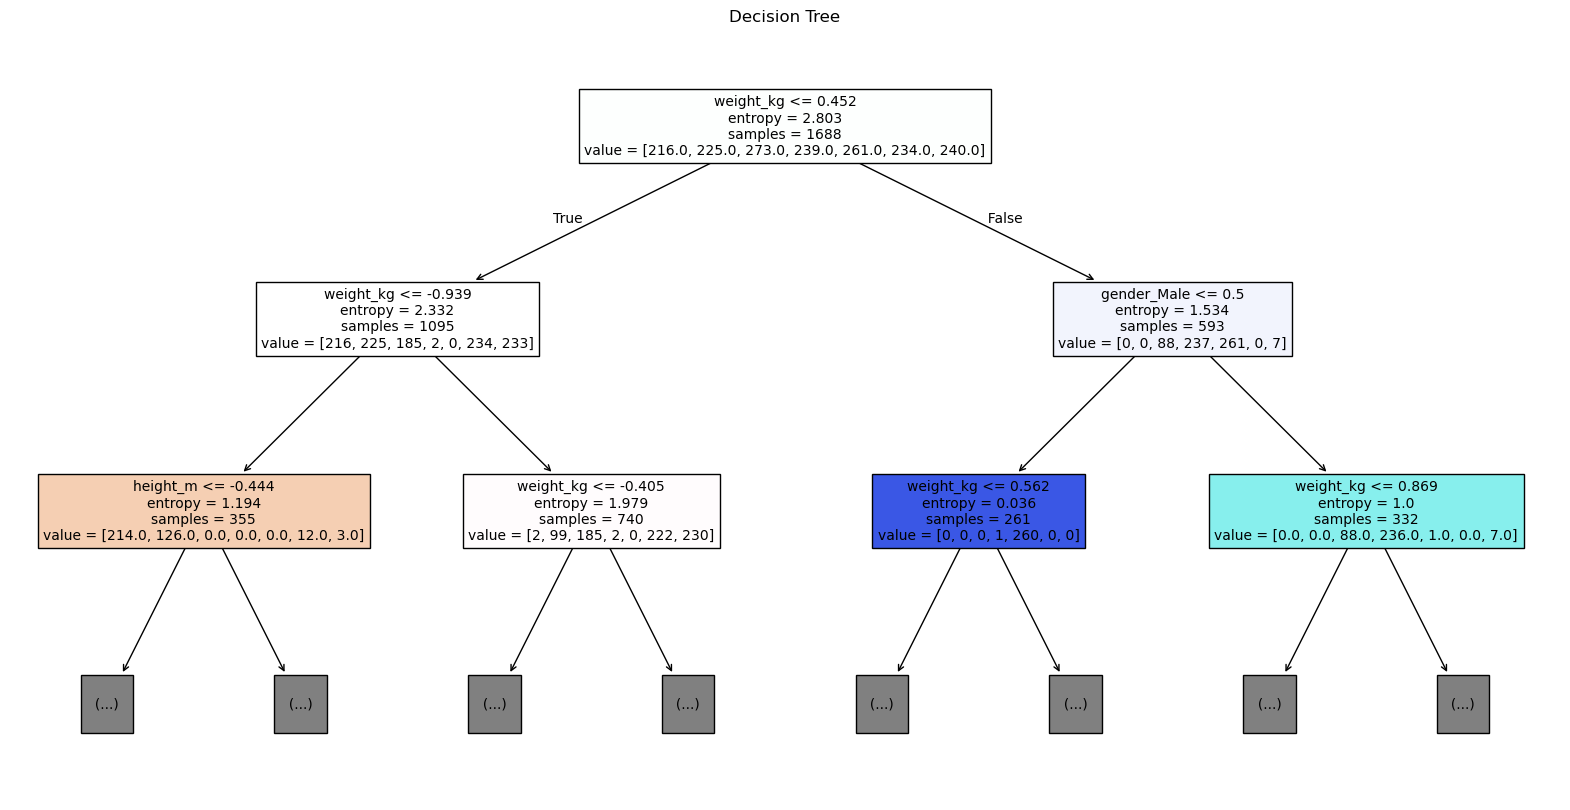


Top 5 Important Features:
               Feature  Importance
             weight_kg    0.624868
              height_m    0.196542
           gender_Male    0.120838
                   age    0.023658
high_caloric_food_freq    0.009961


In [75]:
# Get names of features after transformation
num_features = numerical_cols

# Get nominal feature names (one-hot encoded)
nom_features = best_dt.named_steps['preprocessor']\
                     .named_transformers_['nom']\
                     .get_feature_names_out(nominal_cols)

# Get ordinal feature names
ord_features = ordinal_cols  # These keep their original names in OrdinalEncoder

# Combine all feature names
feature_names = np.concatenate([num_features, nom_features, ord_features])

plt.figure(figsize=(20, 10))
plot_tree(best_dt.named_steps['classifier'], 
          feature_names=feature_names, 
          filled=True, 
          max_depth=2,  # Here, we limit the size of the depth to make the plot clearer
          fontsize=10)
plt.title("Decision Tree")
plt.savefig("../plots/decision_tree_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance
importance = best_dt.named_steps['classifier'].feature_importances_
importance_df_dt = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df_dt = importance_df_dt.sort_values(by='Importance', ascending=False)

# Display the top features
print("\nTop 5 Important Features:")
print(importance_df_dt.head(5).to_string(index=False)) # Not showing index

#### Result interpretation:  

The best performing model uses the entropy criterion for splitting and has the max depth hyperparameter set a 15. There are minimal constraints on the samples per leaf (1) and samples per split (2). This results in a deep tree of max depth (***ADD MAX DEPTH CODE***).  

With these hyperparameters, the model performed well in training and validation: reaching a cross-validation accuracy of 0.9479. On unseen data, the model performs even slightly better, suggesting that the model generalizes very well to new data and does not overfit. However, it is also suspicious that the model performs that well and even better on new data. This is something we will discuss in detail in the comparison and conclusion section below.  

Concerning, the Feature Importance, we can observe that the most influential features are biometric features like the body composition measures "weight" and "height", with a value of approx. 0.625 and 0.197 respectively. However, behavioural features like "high caloric food intake" are way less predictive. This presents a challenge, as both weight and height directly influence the Body-Mass-Index, which was used to define the obesity classification labels. Our main goal was to analyse which lifestyle factors do contribute to obesity levels. This issue will be discussed in greater detail in the conclusion of this notebook.  
  
  
Possible enhancements:
- depth vs. accuracy plot
- comment and improve plot

---

# 2. Random Forest Classifier  

Now, as previously, we will run the `RandomForestClassifier` using a pipeline and `GridSearch`. Once again we are using 5-fold-cross-validation.

In [25]:
# Create pipeline
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_rf:.4f}")

Best parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.9348

Test Set Performance:
Accuracy: 0.9362


By retrieving the feature names from the transformed dataset, we can not extract and rank the feature importances.

In [37]:
# Helper function to get feature names after preprocessing
def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer"""
    col_names = []
    for transformer_in_columns in column_transformer.transformers_:
        transformer_name, transformer, orig_columns = transformer_in_columns
        if transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(orig_columns)
        else:  # for StandardScaler
            names = orig_columns
        col_names.extend(names)
    return col_names

# Feature importance
feature_importances = best_rf.named_steps['classifier'].feature_importances_
features = get_feature_names(best_rf.named_steps['preprocessor'])

# Create DataFrame for feature importances
importance_df_rf = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nTop 5 Important Features:")
print(importance_df_rf.head(5).to_string(index=False)) # Not showing index


Top 5 Important Features:
        Feature  Importance
      weight_kg    0.333455
            age    0.113978
       height_m    0.110533
    gender_Male    0.048949
vegetables_freq    0.042443


#### Result interpretation:  

After running the GridSearch, the model was optimized using the following hyperparameters:
- max_depth = 20
- n_estimators = 200: number of trees in the forest
- max_features = 'sqrt': each tree considers a random subset of features
- min_samples_leaf = 1 and min_samples_split = 2: these represent minimal constraints on tree splits as in our previous DecisionTreeClassifier.  

With these paramters, the model achieved a cross-validation accuracy of approx. 0.935 and a test set accuracy of approx. 0.936. Once again, the model performs very well in both training/validation and testing, which indicates that the model generalizes well and does not overfit. The potential issues will be discussed below.  

As in our previous tree-based model, biometric features dominate the predictions compared to lifestyle factors. For instance, we still have weight, height, age and gender as the most important features and the lifestyle feature "vegetables_freq" only makes it to the fifth position and has a very low feature importance. The issues and challenges attached to this, will be discussed below.

---

# 3. XGBoost Model

##### <u>Disclaimer:</u>
- XGBoost models can be computationally intensive, especially when using an extensive parameter grid and k-fold cross-validation. Our team experienced computational issues running the models under certain specifications. Therefore, both the `n_jobs` argument in `XGBClassifier` (see pipeline) and in `GridSearchCV` are set to `1`. Feel free to change this argument depending on your device's computational power (setting it to `-1` will use all available CPU cores).
- Because of changes in the scikit-learn and XGBoost APIs over time, there is a version incompatibility between `scikit-learn` and the most recent version of XGBoost. As previously stated, it is necessary to use `scikit-learn==1.5.2`, as specified in the `requirements.txt`.

Now, we can train the XGBoostClassifier. Once more, we use a pipeline and a grid of hyperparamters to run a 5-fold cross-validation and find the best-performing model.

In [27]:
# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, n_jobs=1, 
                                objective='multi:softmax',
                                eval_metric='mlogloss'))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1)
grid_search.fit(X_train, y_train_encoded)

# Get the best model
best_xgb = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred)
accuracy_xgb = accuracy_score(y_test, y_pred)
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_xgb:.4f}")

Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.9668

Test Set Performance:
Accuracy: 0.9574


We can now extract the feature importances from the best model.

In [36]:
# Feature importance
feature_importances = best_xgb.named_steps['classifier'].feature_importances_
features = get_feature_names(best_xgb.named_steps['preprocessor'])

# Create DataFrame for feature importances
importance_df_xgb = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nTop 5 Important Features:")
print(importance_df_xgb.head(5).to_string(index=False)) # Not showing index


Top 5 Important Features:
                 Feature  Importance
           gender_Female    0.384989
               weight_kg    0.148926
  high_caloric_food_freq    0.080496
alcohol_consumption_freq    0.065907
           snacking_freq    0.047533


#### Result interpretation:  

The best parameter according to our grid search are:
- learning_rate = 0.2 (controls how much the model learns at each step)
- max_depth = 3 (shallow trees to reduce overfitting)
- n_estimators = 200 (boosting rounds, i.e., the number of trees)  

With these hyperparamter the model achieves a cross-validation accuracy of 0.9668 and a testing accuracy of 0.9574. This represents the best cross-validation accuracy across our three tree based models. However, the testing accuracy is slightly lower than the one from our simple Decision Tree Classifier.  

What is very interesting in these results are the feature importances. Only the biometric features "female gender" and "weight" made it to the top 5. The three others ones are the lifestyle factors "high caloric food frequency", "alcohol consumption frequency" and "snacking frequency".
Although it must be said that their importance in the model is not really significant. Moreover, the "height" feature did not make it to the most important predictors. Possible explanations will be provided in the comparison below.



---

# Model Evaluation and Comparison

Let's first remind ourselves of the test accuracy of our three models with the plot below.

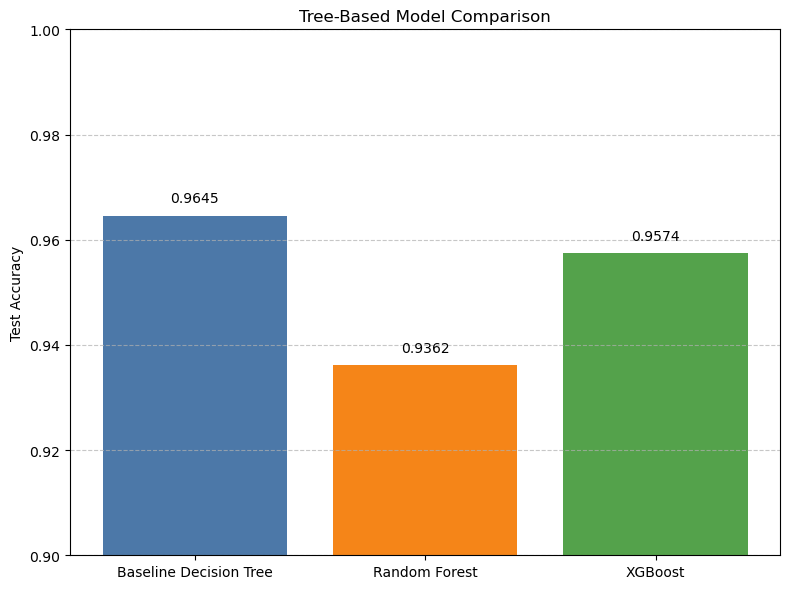

In [42]:
# Plotting the accuracies
labels = ['Baseline Decision Tree', 'Random Forest', 'XGBoost']
accuracies = [accuracy_dt, accuracy_rf, accuracy_xgb]

colors = ['#4C78A8', '#F58518', '#54A24B'] # Custom colors for the bars
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, accuracies, color=colors)

plt.ylabel('Test Accuracy')
plt.title('Tree-Based Model Comparison')
plt.ylim(0.9, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add exact accuracy values above bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.002, f"{v:.4f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("../plots/tree_based_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


**FINISH**

In the plot above, we can observe that our baseline decision tree classifier outperformed the more complex models Random Forest and XGBoost. Although all of them perform exceptionally well.

- Explain why simple DT outperforms...  
- Explain why this is not overfitting... 
- The high accuracy is due to two data issues we have uncovered: data-generation (see below) and label construction (BMI)... This could also be a reason for why we have better testing accuracy than CV accuracy in our first two models. Explain why this could be the case (very good generalization, CV split variability...) and why this is probably the case in a bad sense (the test set not being truly independent!)

Now, we can compare the feature importances of our three models. Let's remind ourselves of the most important features for each model with the following table.

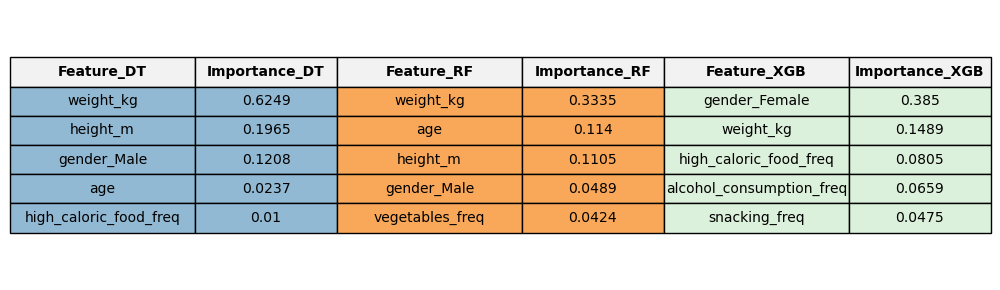

In [73]:
# # Get top 5 features from each model and reset index
top_dt = importance_df_dt.head(5).reset_index(drop=True)
top_rf = importance_df_rf.head(5).reset_index(drop=True)
top_xgb = importance_df_xgb.head(5).reset_index(drop=True)

# Rename columns to identify models
top_dt.columns = ['Feature_DT', 'Importance_DT']
top_rf.columns = ['Feature_RF', 'Importance_RF']
top_xgb.columns = ['Feature_XGB', 'Importance_XGB']

# Strip and convert manually the XGB importance values because of decimal issue
top_xgb['Importance_XGB'] = top_xgb['Importance_XGB'].astype(str).str.strip()
top_xgb['Importance_XGB'] = top_xgb['Importance_XGB'].astype(float).round(4)

# Combine into a single DataFrame
top_combined = pd.concat([top_dt, top_rf, top_xgb], axis=1)

# Ensure all importance columns are float and round to 4 decimals
for col in ['Importance_DT', 'Importance_RF', 'Importance_XGB']:
    top_combined[col] = pd.to_numeric(top_combined[col], errors='coerce').round(4)

# Plotting the table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')  # Hide axes

# Create the table
table = ax.table(
    cellText=top_combined.values,
    colLabels=top_combined.columns,
    cellLoc='center',
    loc='center'
)

# Adjust individual column widths
for (row, col), cell in table.get_celld().items():
    if col in [0, 2, 4]:
        cell.set_width(0.17)
    else:
        cell.set_width(0.13)


# Style settings
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)  # widen columns (especially for feature names)

# Define background colors
model_colors = {
    'DT': '#92B9D3',   # light teal
    'RF': '#F9A85A',   # light orange
    'XGB': '#DCF1DB'   # light pink
}

# Style header
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f2f2f2')
    else:
        # Apply color per column group
        if col in [0, 1]:  # DT columns
            cell.set_facecolor(model_colors['DT'])
        elif col in [2, 3]:  # RF columns
            cell.set_facecolor(model_colors['RF'])
        elif col in [4, 5]:  # XGB columns
            cell.set_facecolor(model_colors['XGB'])

# Save as PNG
plt.tight_layout()
plt.savefig("../plots/top_features_tree_based_models.png", dpi=300, bbox_inches='tight')
plt.show()




**FINISH**
- Biometric features vs. lifestyle features
- Different features for XGBoost (interactions)
- Issue (mentioned before of the label computation...). It would therefore make sense to rereun our models by excluding these feature which are directly used to calculate the BMI and therefore our label. This would give us more insights into which lifestlye features truly matter in predicting obesity levels.

# Feature Exclusion: Running the same models without "Height" and "Weight" predictors

As equally pointed out in the PCA_KNN notebook, the target is directly derived from the Body-Mass-Index which is calculated as follows: $${BMI} = \frac{\text{weight (kg)}}{(\text{height (m)})^2}$$  
It is therefore clear that...  
Therefore, we can run the models again without these strongly predicting features. The following will repeat what we have done above but without the two features "weight" and "height".

## Try Running model with different ordinal encoding

- Follow Jasmin's encoding 

## Add some more plots

- e.g., depth vs accuracy reduction? For all of them
- improve tree plot and add interpretation
